Click [here](https://tensor4all.org/T4AJuliaTutorials/_sources/ipynbs/qft.ipynb) to download the notebook locally.


# Quantum Fourier Transform


In [1]:
using PythonCall: PythonCall
using PythonPlot: pyplot as plt, Figure
using LaTeXStrings

# Displays the matplotlib figure object `fig` and avoids duplicate plots.
_display(fig::Figure) = isinteractive() ? (fig; plt.show(); nothing) : Base.display(fig)
_display(fig::PythonCall.Py) = _display(Figure(fig))

import QuanticsGrids as QG
import TensorCrossInterpolation as TCI
using QuanticsTCI: quanticscrossinterpolate, quanticsfouriermpo

$$
%\newcommand{\hf}{\hat{f}}   %Fourier transform of \bff
%\newcommand{\hF}{\hat{F}}
$$


Consider a discrete function $f_m \in \mathbb{C}^M$, e.g. the 
discretization, $f_m = f(x(m))$, of a one-dimensional function $f(x)$ on a grid $x(m)$. 
Its discrete Fourier transform (DFT) is

$$
\hat{f}_k = \sum_{m=0}^{M-1}   T_{km} f_m , \qquad 
T_{km} =  \tfrac{1}{\sqrt{M}}  e^{- i 2 \pi k \cdot m /M} .
$$

For a quantics grid, $M = 2^\mathcal{R}$ is exponentially large and the (naive) DFT exponentially expensive to evaluate.
However, the QTT representation of $T$ is known to have a low-rank structure and can be represented as a tensor train with small bond dimensions.

Thus, if the input function $f$ is given in the quantics representation as

<img src="https://raw.githubusercontent.com/tensor4all/T4AJuliaTutorials/main/qft1.png" alt="qft1" width="30%">,

$\hat{f} = T f$ can be computed by efficiently contracting the tensor trains for $T$ and $f$ and recompressing the result:

<img src="https://raw.githubusercontent.com/tensor4all/T4AJuliaTutorials/main/qft2.png" alt="qft contraction" width="60%">.

Note that after the Fourier transform, the quantics indices $\sigma_1,\cdots,\sigma_\mathcal{R}$ are ordered in the inverse order of the input indices $\sigma'_1,\cdots,\sigma'_\mathcal{R}$.
This allows construction of the DFT operator with small bond dimensions.



We consider a function $f(x)$, which is the sum of exponential functions, defined on interval $[0,1]$:

$$
f(x) = \sum_p \frac{c_p}{1 - e^{-\epsilon_p}} e^{-\epsilon_p x}.
$$

Its Fourier transform is given by

$$
\hat{f}(k) = \int_0^1 dx \, f(x) e^{i \omega_k x} = - \sum_p \frac{c_p}{i\omega_k - \epsilon_p}.
$$

for $k = 0, 1, \cdots $ and $\omega_k = 2\pi k$.

If you are familiar with quantum field theory, you can think of $f(x)$ as a bosonic correlation function.

In [2]:
coeffs = [1.0, 1.0]
ωs = [100.0, -50.0]

_exp(x, ω) = exp(-ω * x)/ (1 - exp(-ω))

fx(x) = sum(coeffs .* _exp.(x, ωs))

fx (generic function with 1 method)

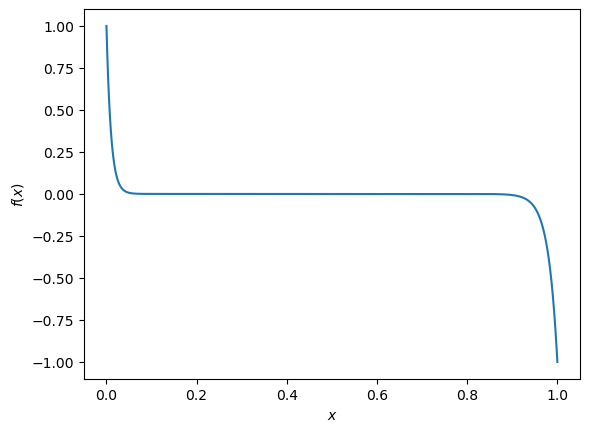

In [3]:
plotx = range(0, 1; length=1000)

fig, ax = plt.subplots()

ax.plot(plotx, fx.(plotx))
ax.set_xlabel(L"x")
ax.set_ylabel(L"f(x)")
_display(fig)

First, we construct a QTT representation of the function $f(x)$.

In [4]:
R = 40
xgrid = QG.DiscretizedGrid{1}(R, 0, 1)

qtci, ranks, errors = quanticscrossinterpolate(Float64, fx, xgrid; tolerance=1e-10)

(QuanticsTCI.QuanticsTensorCI2{Float64}(TensorCrossInterpolation.TensorCI2{Float64} with rank 2, QuanticsGrids.DiscretizedGrid{1}(40, (0.0,), (1.0,), 2, :fused, false), TensorCrossInterpolation.CachedFunction{Float64, UInt128} with 2477 entries), [2, 2, 2], [2.793464338512118e-16, 2.220446049250313e-16, 2.220446049250313e-16])

Second, we compute the Fourier transform of $f(x)$ using the QTT representation of $f(x)$ and the QTT representation of the DFT operator $T$:

$$
\hat{f}_k = \int_0^1 dx \, f(x) e^{i \omega_k x} \approx \frac{1}{M} \sum_{m=0}^{M-1} f_m e^{i 2 \pi k m / M} =  \frac{1}{\sqrt{M}} \sum_{m=0}^{M-1} T_{km} f_m.
$$

for $k = 0, \ldots, M-1$ and $\omega_k = 2\pi k$.
This can be implemented as follows.

In [5]:
# Construct QTT representation of T_{km}
fouriertt = quanticsfouriermpo(R; sign=1.0, normalize=true)

# Apply T_{km} to the QTT representation of f(x)
sitedims = [[2,1] for _ in 1:R]
ftt = TCI.TensorTrain(qtci.tci)
hftt = TCI.contract(fouriertt, ftt; algorithm=:naive, tolerance=1e-8)

hftt *= 1/sqrt(2)^R

@show hftt
;

hftt = TensorCrossInterpolation.TensorTrain{ComplexF64, 3} of rank 18


Let us compare the result with the exact Fourier transform of $f(x)$.

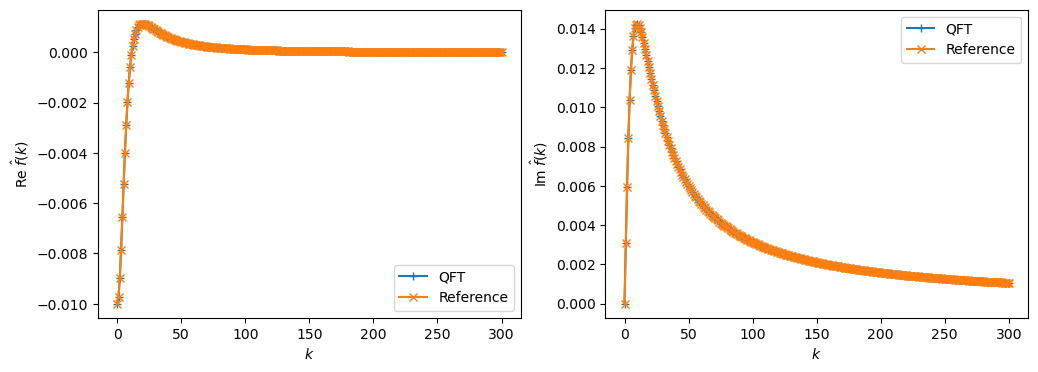

In [6]:
kgrid = QG.InherentDiscreteGrid{1}(R, 0) # 0, 1, ..., 2^R-1

_expk(k, ω) = -1 / (2π * k * im - ω)
hfk(k) = sum(coeffs .* _expk.(k, ωs)) # k = 0, 1, 2, ..., 2^R-1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

plotk = collect(0:300)
y = [hftt(reverse(QG.origcoord_to_quantics(kgrid, x))) for x in plotk] # Note: revert the order of the quantics indices

ax1.plot(plotk, real.(y), marker="+", label="QFT")
ax1.plot(plotk, real.(hfk.(plotk)), marker="x", label="Reference")
ax1.set_xlabel(L"k")
ax1.set_ylabel(L"\mathrm{Re}~\hat{f}(k)")
ax1.legend()

ax2.plot(plotk, imag.(y), marker="+", label="QFT")
ax2.plot(plotk, imag.(hfk.(plotk)), marker="x", label="Reference")
ax2.set_xlabel(L"k")
ax2.set_ylabel(L"\mathrm{Im}~\hat{f}(k)")
ax2.legend()

_display(fig)

The exponentially large quantics grid allows to compute the Fourier transform with high accuracy at high frequencies.
To check this, let us compare the results at high frequencies.

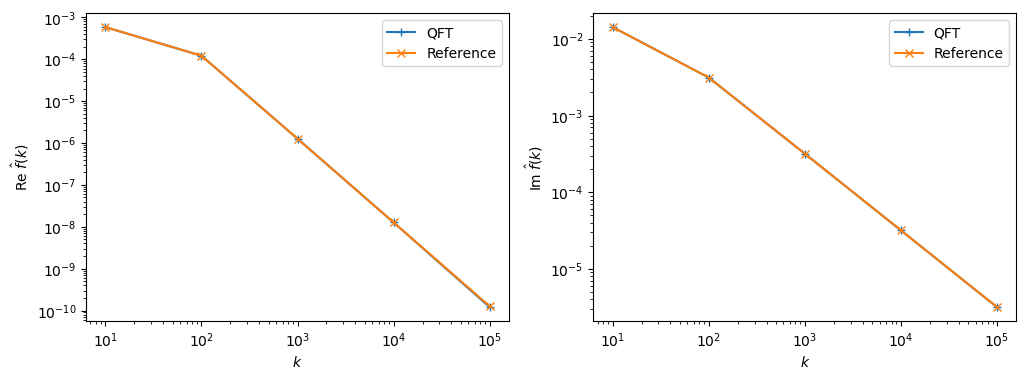

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

plotk = [10^n for n in 1:5]
@assert maximum(plotk) <= 2^R-1
y = [hftt(reverse(QG.origcoord_to_quantics(kgrid, x))) for x in plotk] # Note: revert the order of the quantics indices

ax1.loglog(plotk, abs.(real.(y)), marker="+", label="QFT")
ax1.loglog(plotk, abs.(real.(hfk.(plotk))), marker="x", label="Reference")
ax1.set_xlabel(L"k")
ax1.set_ylabel(L"\mathrm{Re}~\hat{f}(k)")
ax1.legend()

ax2.loglog(plotk, abs.(imag.(y)), marker="+", label="QFT")
ax2.loglog(plotk, abs.(imag.(hfk.(plotk))), marker="x", label="Reference")
ax2.set_xlabel(L"k")
ax2.set_ylabel(L"\mathrm{Im}~\hat{f}(k)")
ax2.legend()

_display(fig)

You may use ITensors.jl to compute the Fourier transform of the function $f(x)$.
The following code explains how to do this.

In [8]:
import TCIITensorConversion
using ITensors
import Quantics: fouriertransform

sites_m = [Index(2, "Qubit,m=$m") for m in 1:R]
sites_k = [Index(2, "Qubit,k=$k") for k in 1:R]

fmps = MPS(ftt; sites=sites_m)

# Apply T_{km} to the MPS representation of f(x) and reply the result by 1/sqrt(M)
# tag="m" is used to indicate that the MPS is in the "m" basis.
hfmps = (1/sqrt(2)^R) * fouriertransform(fmps; sign=1, tag="m", sitesdst=sites_k)

LoadError: ArgumentError: Package Quantics not found in current path.
- Run `import Pkg; Pkg.add("Quantics")` to install the Quantics package.

In [ ]:
# Evaluate Ψ for a given index
_evaluate(Ψ::MPS, sites, index::Vector{Int}) = only(reduce(*, Ψ[n] * onehot(sites[n] => index[n]) for n in 1:length(Ψ)))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

plotk = [10^n for n in 1:5]
@assert maximum(plotk) <= 2^R-1
y = [_evaluate(hfmps, reverse(sites_k), reverse(QG.origcoord_to_quantics(kgrid, x))) for x in plotk] # Note: revert the order of the quantics indices

ax1.loglog(plotk, abs.(real.(y)), marker="+", label="QFT")
ax1.loglog(plotk, abs.(real.(hfk.(plotk))), marker="x", label="Reference")
ax1.set_xlabel(L"k")
ax1.set_ylabel(L"\mathrm{Re}~\hat{f}(k)")
ax1.legend()

ax2.loglog(plotk, abs.(imag.(y)), marker="+", label="QFT")
ax2.loglog(plotk, abs.(imag.(hfk.(plotk))), marker="x", label="Reference")
ax2.set_xlabel(L"k")
ax2.set_ylabel(L"\mathrm{Im}~\hat{f}(k)")
ax2.legend()

_display(fig)

## TODO
* 2D Fourier transform